In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
import re
# File Loading
from trace_file_loader import get_breath_df

# SkLearn Packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Torch Packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence 
from torch.autograd import Variable

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Load and Clean Data

CNNs assume a fixed input size so we need to assume a fixed size and truncate or pad the sentences as needed.

In [2]:
# breath_df = get_breath_df('data_sdx_',full_trace=True)
# breath_df.to_pickle('breath_pickle_full_trace')

In [3]:
breath_df = pd.read_pickle('breath_pickle')
breath_df.head(2)

,Trace,Csv_breath_holds,Data_breath_holds,Full_trace,breathhold_idx,bh_start_end
0,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023...",31.29,31.69,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023...","[2661, 2662, 2663, 2664, 2665, 2666, 2667, 266...","(2661, 5829)"
1,"[0.0006, 0.0009, 0.0013, 0.0017, 0.0022, 0.002...",30.61,31.40,"[0.0006, 0.0009, 0.0013, 0.0017, 0.0022, 0.002...","[2386, 2387, 2388, 2389, 2390, 2391, 2392, 239...","(2386, 5525)"


In [4]:
under2 = breath_df[abs(breath_df['Csv_breath_holds']-breath_df['Data_breath_holds'])<=2]

In [5]:
median_bh = under2['Data_breath_holds'].median()
under2['class'] = np.where(under2['Data_breath_holds'] < median_bh, 0, 1) # create encoded column: short (0), long (1)

In [6]:
q25 = under2['Data_breath_holds'].quantile(.25)
q75 = under2['Data_breath_holds'].quantile(.75)

In [7]:
under2 = under2[(under2['Data_breath_holds'] < q25) | (under2['Data_breath_holds'] > q75)] # only consider breathholds in upper and lower quartiles

In [8]:
under2['class'] = np.where(under2['Data_breath_holds'] < q25, 0, 1) # create encoded column: short (0), long (1)

In [9]:
under2.head()

,Trace,Csv_breath_holds,Data_breath_holds,Full_trace,breathhold_idx,bh_start_end,class
9,"[0.0008, 0.0018, 0.0021, 0.0024, 0.0028, 0.003...",25.44,25.05,"[0.0008, 0.0018, 0.0021, 0.0024, 0.0028, 0.003...","[2205, 2206, 2207, 2208, 2209, 2210, 2211, 221...","(2205, 4709)",0
13,"[0.0004, 0.0011, 0.002, 0.0032, 0.0045, 0.006,...",24.41,24.44,"[0.0004, 0.0011, 0.002, 0.0032, 0.0045, 0.006,...","[2095, 2096, 2097, 2098, 2099, 2100, 2101, 210...","(2095, 4538)",0
14,"[0.0002, 0.0006, 0.001, 0.0015, 0.002, 0.0026,...",26.02,25.66,"[0.0002, 0.0006, 0.001, 0.0015, 0.002, 0.0026,...","[2069, 2070, 2071, 2072, 2073, 2074, 2075, 207...","(2069, 4634)",0
15,"[0.0002, 0.0007, 0.0015, 0.0026, 0.004, 0.0057...",26.43,25.11,"[0.0002, 0.0007, 0.0015, 0.0026, 0.004, 0.0057...","[2070, 2071, 2072, 2073, 2074, 2075, 2076, 207...","(2070, 4580)",0
16,"[0.0016, 0.0021, 0.0028, 0.0037, 0.0047, 0.005...",25.27,25.06,"[0.0016, 0.0021, 0.0028, 0.0037, 0.0047, 0.005...","[2171, 2172, 2173, 2174, 2175, 2176, 2177, 217...","(2171, 4676)",0


# Split and Normalize Data

In [10]:
df = under2

In [11]:
x_train, x_test, y_train, y_test = train_test_split(df['Trace'], df['class'], test_size=0.70)

In [12]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=1)

In [13]:
def normalize(x_train, x_val):
    u = np.mean([item for sublist in x_train for item in sublist])
    std = np.std([item for sublist in x_train for item in sublist])
    
    train = []
    for row in x_train:
        normalized_row = []
        for x in row:
            normalized_row.append((x-u)/std)
        train.append(normalized_row)
    
    val = []
    for row in x_val:
        normalized_row = []
        for x in row:
            normalized_row.append((x-u)/std)
        val.append(normalized_row)
    
    return train, val

In [14]:
x_train2, x_val2 = normalize(x_train, x_val)
x_train2, x_test2 = normalize(x_train, x_test)

## Equalize Lengths

In [15]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [16]:
def equalize_lengths(df, trim_len):
    equal_traces = []
    for i in range(len(df)):
        curve = df[i]
        if len(curve) > trim_len:
            start_idx = len(curve)-trim_len
            equal_traces.append(curve[start_idx:])
        elif len(curve) < trim_len:
            num_zeros = trim_len - len(curve)
            
            random_nums = (np.random.random_sample(num_zeros)-0.5)
            box_pts = 100
            box = np.ones(box_pts)/box_pts
            random_nums = np.convolve(random_nums, box, mode = 'same')
            random_nums = random_nums[:num_zeros]
            #zeros = np.zeros([1, num_zeros])[0]
            equal_traces.append(np.concatenate((random_nums, curve)))
        else:
            equal_traces.append(curve)
 
    return np.array(equal_traces)

In [17]:
x_train3 = equalize_lengths(x_train2, 10000)
x_val3 = equalize_lengths(x_val2, 10000)
x_test3 = equalize_lengths(x_test2, 10000)

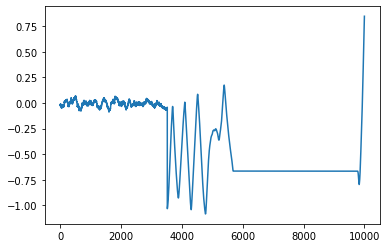

In [18]:
plt.plot(x_train3[0])

x_train3## CNN Model

In [20]:
class myCNN(nn.Module):
    
    def __init__(self, D):
        super(myCNN, self).__init__()
        self.conv_3 = nn.Conv1d(in_channels=1, out_channels=100, kernel_size=3)
        self.conv_4 = nn.Conv1d(in_channels=1, out_channels=100, kernel_size=4)
        self.conv_5 = nn.Conv1d(in_channels=1, out_channels=100, kernel_size=5)
        
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(300, 1)
        
    def forward(self, x):
        x = torch.unsqueeze(x, dim=1)
        x3 = F.relu(self.conv_3(x))
        x4 = F.relu(self.conv_4(x))
        x5 = F.relu(self.conv_5(x))
        
        x3 = nn.MaxPool1d(kernel_size = 9998)(x3)
        x4 = nn.MaxPool1d(kernel_size = 9997)(x4)
        x5 = nn.MaxPool1d(kernel_size = 9996)(x5)
        
        out = torch.cat([x3, x4, x5], 2)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        
        return self.fc(out) 

In [21]:
# Testing the model
model = myCNN(1)

In [22]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)

+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
| conv_3.weight |    300     |
|  conv_3.bias  |    100     |
| conv_4.weight |    400     |
|  conv_4.bias  |    100     |
| conv_5.weight |    500     |
|  conv_5.bias  |    100     |
|   fc.weight   |    300     |
|    fc.bias    |     1      |
+---------------+------------+
Total Trainable Params: 1801


1801

# Dataset and Dataloader

In [24]:
from torch.utils.data import Dataset

class timeseries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len

In [25]:
dataset = timeseries(x_train3, y_train)
valid_dataset = timeseries(x_val3,y_val)
test_dataset = timeseries(x_test3,y_test)

In [26]:
train_loader = DataLoader(dataset,shuffle=False,batch_size=100)
val_loader = DataLoader(valid_dataset,shuffle=False,batch_size=100)
test_loader = DataLoader(test_dataset,shuffle=False,batch_size=100)

## Training

In [27]:
model = myCNN(1).cuda()

In [28]:
def train_epocs(model, epochs=10, lr=0.01, fname='1'):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    
    losses = []
    for i in range(epochs):
        model.train()
        current_loss = []
        for x, y in train_loader:
            x = x.cuda()
            y = y.unsqueeze(1).cuda()
            y_hat = model(x)

            loss = F.binary_cross_entropy_with_logits(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            current_loss.append(loss.item())
        train_loss = np.mean(current_loss)
        print("Train loss:", train_loss)
        val_loss = test_metrics(model)
        losses.append((train_loss, val_loss))
        

    return losses

In [29]:
def test_metrics(m):
    m.eval()
    losses = []
    for x, y in val_loader:
        x = x.cuda()
        y = y.unsqueeze(1).cuda()
        y_hat = m(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        losses.append(loss.item())
        
        y_pred = y_hat > 0
        correct = (y_pred.float() == y).float().sum()
        accuracy = correct/y_pred.shape[0]
    #print("test loss %.3f and accuracy %.3f" % (np.mean(losses), accuracy))
    return np.mean(losses)

In [31]:
losses = train_epocs(model, epochs=100, lr=0.001)

Train loss: 0.6648952007293701
Train loss: 0.6848816275596619
Train loss: 0.679382598400116
Train loss: 0.6722339868545533
Train loss: 0.678576672077179
Train loss: 0.6722598671913147
Train loss: 0.6747703671455383
Train loss: 0.6888570666313172
Train loss: 0.6907015323638916
Train loss: 0.6794878005981445
Train loss: 0.675866448879242
Train loss: 0.6713438868522644
Train loss: 0.6873887538909912
Train loss: 0.6823583960533142
Train loss: 0.6848042488098145
Train loss: 0.6783140778541565
Train loss: 0.6735916495323181
Train loss: 0.6763245224952698
Train loss: 0.6773063659667968
Train loss: 0.6775026321411133
Train loss: 0.6665579795837402
Train loss: 0.6828677654266357
Train loss: 0.6719366431236267
Train loss: 0.6802070379257202
Train loss: 0.668475067615509
Train loss: 0.6780072808265686
Train loss: 0.6855942845344544
Train loss: 0.6772866129875184
Train loss: 0.66598539352417
Train loss: 0.6717429399490357
Train loss: 0.6864415645599365
Train loss: 0.6786979913711548
Train loss: 0.

In [32]:
val = [x[1] for x in losses]
train = [x[0] for x in losses]

In [33]:
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1]

In [ ]:
losses = []
for lr in learning_rates:
    loss = train_epocs(model, epochs=100, lr=lr, fname=str(lr))
    losses.append(loss)

Train loss: 0.6660215020179748
Train loss: 0.6680529713630676
Train loss: 0.6724198341369629
Train loss: 0.6680415630340576
Train loss: 0.6766475915908814
Train loss: 0.6692710041999816
Train loss: 0.6677425265312195
Train loss: 0.6723647952079773
Train loss: 0.6742480635643006
Train loss: 0.6655742168426514
Train loss: 0.6659060597419739
Train loss: 0.673697829246521
Train loss: 0.665687108039856
Train loss: 0.6697576761245727
Train loss: 0.6617261052131653
Train loss: 0.6723013043403625
Train loss: 0.6640976786613464
Train loss: 0.6652062177658081
Train loss: 0.6738945126533509
Train loss: 0.6696599841117858
Train loss: 0.6672579884529114
Train loss: 0.6707145214080811
Train loss: 0.6750615239143372
Train loss: 0.6769431591033935
Train loss: 0.6676649928092957
Train loss: 0.6739196896553039
Train loss: 0.6714290738105774
Train loss: 0.6674849152565002
Train loss: 0.6805281400680542
Train loss: 0.6802033543586731
Train loss: 0.6690000057220459
Train loss: 0.676571273803711
Train loss:

# Loss Plots

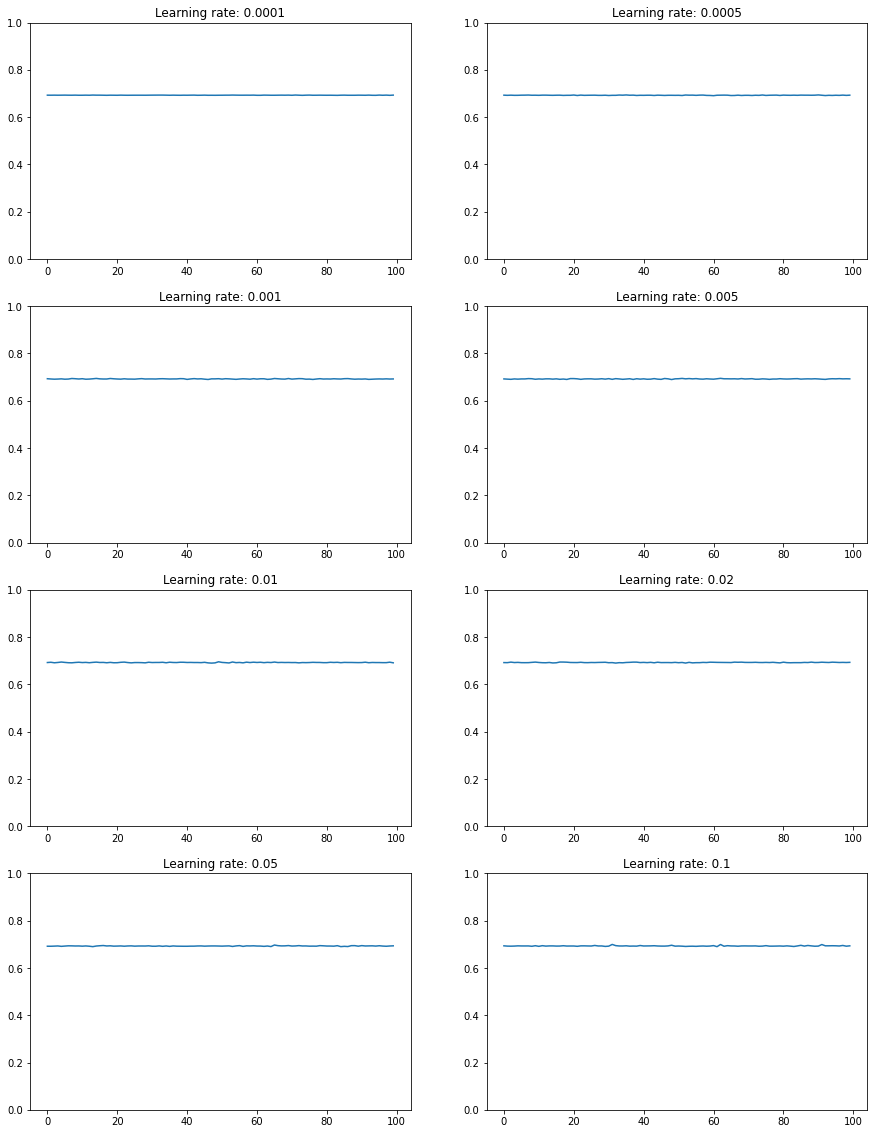

In [132]:
fig, ax = plt.subplots(4,2, figsize = (15,20))
k = 0
for i in range(4):
    for j in range(2):
        ax[i, j].plot(losses[k])
        ax[i, j].set_ylim([0,1])
        ax[i, j].set_title(f'Learning rate: {learning_rates[k]}')
        k += 1